In [155]:

import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')


#For biotype
import squidpy as sq
import anndata as ad
import pandas as pd
import scipy
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import gc
from scipy.stats import pearsonr

gc.enable()
import  cv2 as cv

In [158]:
location_input="/workdir/lt425/202402_stereoseq/nontotal/figures/data/D611/input/"
location_out = "/workdir/lt425/202402_stereoseq/nontotal/figures/data/D611/" 


# host adata

In [159]:
######Load scanpy object

host_adata = location_input+"UniqueAndMultEM.h5ad"

adata_host = sc.read_h5ad(host_adata)

adata_host.X = adata_host.X.astype(int)
adata_host.var_names = adata_host.var_names.astype('object')
adata_host.var_names_make_unique()

adata_host.var_names = adata_host.var_names.str.upper()


In [160]:
bc_map=location_input + "C02927D611.barcodeToPos.h5.txt" 
bc_map_df = pd.read_csv(bc_map,sep='\t',index_col=0, header=None)
bc_map_df=bc_map_df.reindex(adata_host.obs.index)
bc_map_df.columns = ["X","Y"]
bc_map_df

,X,Y
AAAAAAAAAACCACTTCAATTATCA,4882,3505
AAAAAAAAAAGACGAATCTAGAACT,6300,7368
AAAAAAAAACAATTTAGGCTTTTTA,6242,5615
AAAAAAAAAGTGGCCGCTTGTCTCG,1863,665
AAAAAAAAATTCTTGCTAGGTTCGT,7808,3230
...,...,...
TTTTTTTTTGAACGTCCACGAGTCC,9304,6707
TTTTTTTTTGACTTGTTTACACGGA,4107,3168
TTTTTTTTTGCAACACTCATTCGGC,8194,3555
TTTTTTTTTGCGGTTGTCCTTGCGA,6619,2700


In [161]:
bc_map_df=bc_map_df.reindex(adata_host.obs.index)
bc_map_df.columns = ["X","Y"]

#### Adding spatial information
adata_host.obsm['spatial'] = bc_map_df[['X', 'Y']].values

adata_host.uns['spatial'] = {'coordinates':  adata_host.obsm['spatial']}

In [162]:
adata_host.var['total'] = adata_host.X.sum(axis=0).T
adata_host.obs['total_counts'] = adata_host.X.sum(axis=1)
adata_host

AnnData object with n_obs × n_vars = 5101321 × 56973
    obs: 'total_counts'
    var: 'total'
    uns: 'spatial'
    obsm: 'spatial'

In [163]:
adata_host.write( location_out+"adata_host.h5ad")

# Nonhost From mtx to adata

In [166]:


barcodes = pd.read_csv(location_input+ 'spatialbcd.txt', header=None, names=['barcodes'])
features = pd.read_csv(location_input + 'splist.txt', header=None, names=['features'])
matrix = sc.read_mtx(location_input + 'kraken_output_mat.mtx')

# make annData object
adata_unmap = anndata.AnnData(X=matrix.X, obs=barcodes, var=features)


In [167]:
adata_unmap.X = adata_unmap.X.astype(int)
adata_unmap.var_names = features['features']
adata_unmap.obs_names = barcodes['barcodes']
adata_unmap.var_names_make_unique()

adata_unmap.obs.index = adata_unmap.obs.index.drop_duplicates()
adata_unmap.obs.index = adata_unmap.obs.index.astype(str)
adata_unmap.var.index = adata_unmap.var.index.astype(str)


In [168]:
bc_map=location_input + "C02927D611.barcodeToPos.h5.txt" 
bc_map_df = pd.read_csv(bc_map,sep='\t',index_col=0, header=None)
bc_map_df=bc_map_df.reindex(adata_unmap.obs.index)
bc_map_df.columns = ["X","Y"]
bc_map_df

,X,Y
barcodes,,
GCTGATCCCCGTTTGACCACCCTAC,6365,5464
GGGTATAGCTACGAGTTCTGGATAC,6312,3784
TGCTAATCGCCCGAGAGGTTTGTCC,5612,3692
AATCCAGGCGTGCTTGGTCGTGAAT,6473,6062
GGACCGATGAGTGTTTTATCAGTTT,6514,4313
...,...,...
AGCAGGTTACCTATCAGATGATCCC,3007,3746
TGTAACTGCTCCGTCAGACACCTTC,5697,10353
CGCAATTCCGTATTTCTACGTCATG,9917,2605


In [169]:
#### Adding spatial information

adata_unmap.obsm['spatial'] = bc_map_df[['X', 'Y']].values

adata_unmap.uns['spatial'] = {'coordinates':  adata_unmap.obsm['spatial']}

In [170]:
adata_unmap.var['total'] = adata_unmap.X.sum(axis=0).T
adata_unmap.obs['total_counts'] = adata_unmap.X.sum(axis=1)

In [171]:
adata_unmap.write_h5ad(location_out+"adata_unmap.h5ad")

# Define boundaries

In [172]:
# microscopy image greyscale

ref_img = cv.imread(location_input + 'ssDNA_C02927D611_regist.tif', cv.IMREAD_GRAYSCALE)



True

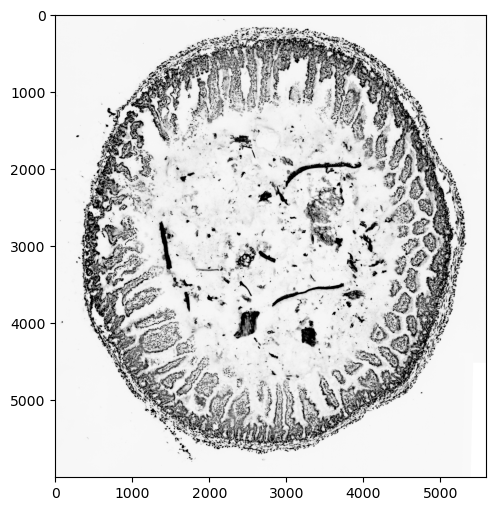

In [173]:
fig, ax = plt.subplots(figsize=(6,6))
xmin = 3400
xmax = 9000
ymin = 1900
ymax = 7900
value_max = 40
temp_img = ref_img[ymin:ymax,xmin:xmax]
temp_img[temp_img >= value_max] = value_max

temp_img = temp_img / value_max * 255 

ax.imshow(temp_img, cmap = 'Greys')
ax.set_aspect('equal')

cv.imwrite(location_out + 'ssDNA_C02929E514_regist.jpg', temp_img)

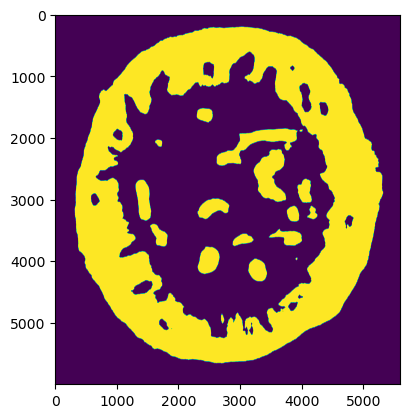

In [174]:

import cv2 as cv
img = location_out + 'ssDNA_C02929E514_regist.jpg' 
img_color = cv.imread(img) 

threshold = 80 

# make a blur image 
img_gray = cv.imread(img,cv.IMREAD_GRAYSCALE)
img_blur = cv.blur(img_gray,(200,200))

# make a binary image
ret, img_binary = cv.threshold(img_blur, threshold, 255, cv.THRESH_BINARY) 

plt.imshow(img_binary)

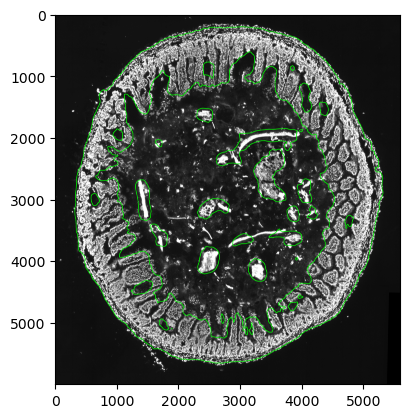

In [175]:
# extract boundaries
contours, hierarchy = cv.findContours(img_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 
img_color_temp = img_color.copy()
img_color_with_contours = cv.drawContours(img_color_temp, contours, -1, (0,255,0), 10)

plt.imshow(img_color_with_contours)

In [176]:
# list of boundaries
lengths_with_contours =  [(len(contour), contour) for contour in contours]

# sort by length
sorted_lengths_with_contours = sorted(lengths_with_contours, key=lambda x: x[0], reverse=True)

# select
contour_lumen = sorted_lengths_with_contours[0][1]
contour_tissue = sorted_lengths_with_contours[1][1] 


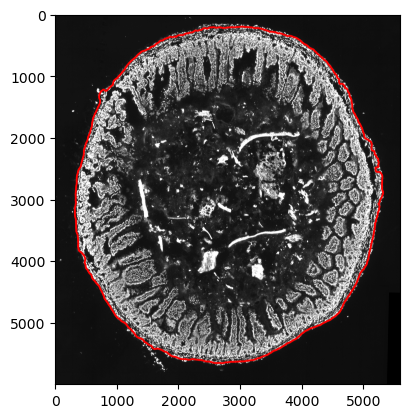

In [177]:
contour = contour_tissue
img_color_temp = img_color.copy()
img_color_with_contours = cv.drawContours(img_color_temp, [contour], -1, (255,0,0), 30) 
plt.imshow(img_color_with_contours)
plt.show()

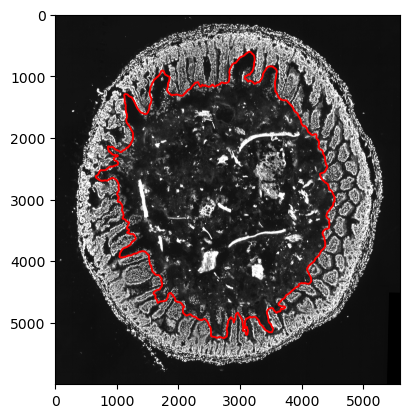

In [178]:
contour = contour_lumen
img_color_temp = img_color.copy()
img_color_with_contours = cv.drawContours(img_color_temp, [contour], -1, (255,0,0), 30) 
plt.imshow(img_color_with_contours)
plt.show()

In [179]:
# back to original coordinate
target_coord = contour_lumen
contour_coord = np.array([target_coord.T[0] + xmin, target_coord.T[1] + ymin]).T
contour_lumen = contour_coord.reshape(contour_coord.shape[0], 2)


target_coord =  contour_tissue
contour_coord = np.array([target_coord.T[0] + xmin, target_coord.T[1] + ymin]).T
contour_tissue = contour_coord.reshape(contour_coord.shape[0], 2)

In [180]:
np.savetxt(location_out+"contour_lumen.csv", contour_lumen, delimiter=",")
np.savetxt(location_out+"contour_tissue.csv", contour_tissue, delimiter=",")


In [181]:
def get_points_inside_contour(contour, image_shape):

    mask = np.zeros(image_shape, dtype=np.uint8)
    
    contour = contour.astype(np.int32)
    cv.fillPoly(mask, [contour], 1)
    
    # inside =1
    points_inside = np.column_stack(np.where(mask == 1))
    
    return points_inside.tolist()


points_inside_lumen = get_points_inside_contour(contour_lumen[:, [1, 0]], ( int(contour_lumen.T[0].max()), int(contour_lumen.T[1].max())))

points_inside_tissue = get_points_inside_contour(contour_tissue[:, [1, 0]], ( int(contour_tissue.T[0].max()), int(contour_tissue.T[1].max())))


In [182]:
np.savetxt(location_out+"coordinates_lumen.csv", points_inside_lumen, delimiter=",")
np.savetxt(location_out+"coordinates_wholetissue.csv", points_inside_tissue, delimiter=",")

In [183]:
location_out


'/workdir/lt425/202402_stereoseq/nontotal/figures/data/D611/'

In [184]:
import numpy as np
adata = adata_unmap

points = points_inside_lumen

points_inside_set = set(map(tuple, points))
positions = adata.obsm['spatial'].astype(int)
mask_inside = np.array([tuple(pos) in points_inside_set for pos in positions])
adata_unmap.obs['mask_lumen'] = mask_inside


points = points_inside_tissue

points_inside_set = set(map(tuple, points))
positions = adata.obsm['spatial'].astype(int)
mask_inside = np.array([tuple(pos) in points_inside_set for pos in positions])
adata.obs['mask_wholetissue'] = mask_inside

adata.obs['mask_tissue'] = adata.obs['mask_wholetissue']
adata.obs.loc[adata.obs['mask_wholetissue'] & adata.obs['mask_lumen'], 'mask_tissue'] = False

adata_unmap = adata

In [185]:
print(adata_unmap.obs['mask_lumen'].sum())
print(adata_unmap.obs['mask_tissue'].sum())
print(adata_unmap.obs['mask_wholetissue'].sum())

3590085
1347973
4938058


(1900.0, 7900.0)

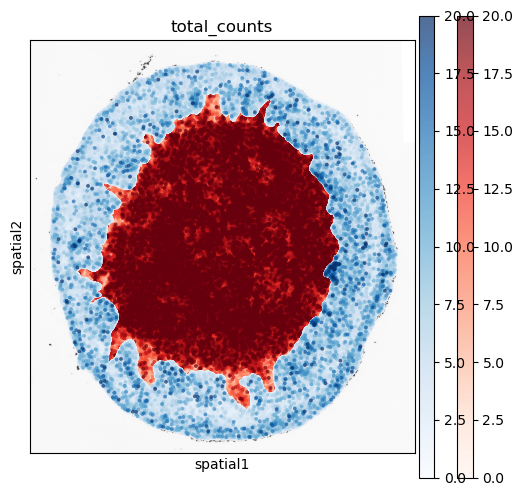

In [186]:

import copy
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(ref_img, vmax=50, cmap = 'Greys')


sc.pl.embedding(
    adata_unmap[adata_unmap.obs['mask_lumen']] , 
    basis="spatial", 
    use_raw=False,
    color=['total_counts'], 
    cmap='Reds', 
    na_color='grey',
    vmin=0,
    show=False,
    vmax = 20,
    alpha=0.7,
    size=30,
    ax=ax
)
sc.pl.embedding(
    adata_unmap[adata_unmap.obs['mask_tissue']] , 
    basis="spatial", 
    use_raw=False,
    color=['total_counts'], 
    cmap='Blues', 
    na_color='grey',
    vmin=0,
    show=False,
    vmax = 20,
    alpha=0.7,
    size=30,
    ax=ax
)


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [187]:
import numpy as np
adata = adata_host

points = points_inside_lumen

points_inside_set = set(map(tuple, points))
positions = adata.obsm['spatial'].astype(int)
mask_inside = np.array([tuple(pos) in points_inside_set for pos in positions])
adata_host.obs['mask_lumen'] = mask_inside


points = points_inside_tissue

points_inside_set = set(map(tuple, points))
positions = adata.obsm['spatial'].astype(int)
mask_inside = np.array([tuple(pos) in points_inside_set for pos in positions])
adata.obs['mask_wholetissue'] = mask_inside

adata.obs['mask_tissue'] = adata.obs['mask_wholetissue']
adata.obs.loc[adata.obs['mask_wholetissue'] & adata.obs['mask_lumen'], 'mask_tissue'] = False

adata_host = adata


In [188]:
print(adata_host.obs['mask_lumen'].sum())
print(adata_host.obs['mask_tissue'].sum())
print(adata_host.obs['mask_wholetissue'].sum())

2098278
1843252
3941530


(1900.0, 7900.0)

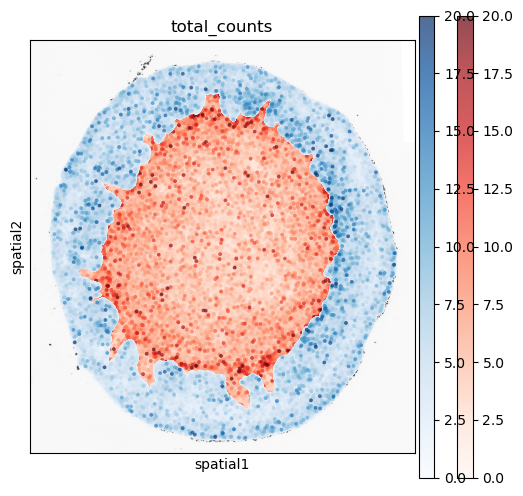

In [189]:

import copy
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.imshow(ref_img, vmax=50, cmap = 'Greys')


sc.pl.embedding(
    adata_host[adata_host.obs['mask_lumen']] , 
    basis="spatial", 
    use_raw=False,
    color=['total_counts'], 
    cmap='Reds', 
    na_color='grey',
    vmin=0,
    show=False,
    vmax = 20,
    alpha=0.7,
    size=30,
    ax=ax
)
sc.pl.embedding(
    adata_host[adata_host.obs['mask_tissue']] , 
    basis="spatial", 
    use_raw=False,
    color=['total_counts'], 
    cmap='Blues', 
    na_color='grey',
    vmin=0,
    show=False,
    vmax = 20,
    alpha=0.7,
    size=30,
    ax=ax
)


plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [190]:
adata_host.write( location_out+"adata_host.h5ad")
adata_unmap.write_h5ad(location_out+"adata_unmap.h5ad")

# Host molecular type

In [191]:
#change dir and load DWM utils

os.chdir(f"/workdir/dwm269/totalRNA/STRS-HD")
from scripts.py.utils import *
from scripts.py.plots import *

In [192]:
# Read the .tsv file
gtf_info = pd.read_csv("resources/gene_lists/GRCm39_GENCODEM32_ReoT1L_gene_info_gtf.tsv", sep="\t")
gtf_info = gtf_info.drop_duplicates(subset=['GENEID'], keep='first')

# Remove period/decimal suffixes from ensembl IDs
gtf_info['GeneID'] = gtf_info['GENEID'].str.split('.').str[0]

# Extract chromosome value before the colon
gtf_info['chr'] = gtf_info['Chromosome'].str.split(':').str[0]

# Add '.1' to the Reovirus gene names to match the gtf file...
gtf_info["GENEID"] = [f"{GENE}.1" if 'T1LReovirus' in GENE else GENE for GENE in gtf_info['GENEID']]

print(f"Using {len(gtf_info['GENEID'].unique())} ensembl IDs, from {gtf_info['GeneSymbol'].nunique()} genes, and {gtf_info['Biotype'].nunique()} biotypes...\n")

# # Display the first few rows
print(gtf_info.head())
# # print(gtf_info.tail())

gtf_info['GeneSymbol'] = gtf_info['GeneSymbol'].str.upper()


Using 56973 ensembl IDs, from 56825 genes, and 38 biotypes...

                 GENEID     GeneSymbol            Chromosome  \
0  ENSMUSG00000102693.2  4933401J01Rik  chr1:3143476-3144545   
1  ENSMUSG00000064842.3        Gm26206  chr1:3172239-3172348   
2  ENSMUSG00000051951.6           Xkr4  chr1:3276124-3741721   
3  ENSMUSG00000102851.2        Gm18956  chr1:3322980-3323459   
4  ENSMUSG00000103377.2        Gm37180  chr1:3435954-3438772   

                Biotype Strand              GeneID   chr  
0                   TEC      +  ENSMUSG00000102693  chr1  
1                 snRNA      +  ENSMUSG00000064842  chr1  
2        protein_coding      -  ENSMUSG00000051951  chr1  
3  processed_pseudogene      +  ENSMUSG00000102851  chr1  
4                   TEC      -  ENSMUSG00000103377  chr1  


In [193]:

adata_host.var['Biotype'] = list(gtf_info['Biotype'])
adata_host.var['Biotype']

4933401J01RIK                     TEC
GM26206                         snRNA
XKR4                   protein_coding
GM18956          processed_pseudogene
GM37180                           TEC
                         ...         
T1LREOL1-AS             gene_version1
T1LREOL2                gene_version1
T1LREOL2-AS             gene_version1
T1LREOL3                gene_version1
T1LREOL3-AS             gene_version1
Name: Biotype, Length: 56973, dtype: object

In [194]:
biotypes = list(set(adata_host.var['Biotype']))

for i in biotypes:
    adata_temp = adata_host[:,adata_host.var['Biotype'] == i]
    adata_host.obs['type_'+i] = adata_temp.X.sum(axis=1) #### TEC overlap with gene name
    print(i+"\t" + str(len(adata_temp.var))+ "\t" + str(adata_host.obs['type_'+i].sum()))


snoRNA	1507	12093
scRNA	1	0
IG_LV_gene	4	0
rRNA	354	1074445
IG_C_gene	13	3077
TR_J_pseudogene	10	0
ribozyme	22	129
unitary_pseudogene	61	190
IG_C_pseudogene	1	0
TR_D_gene	4	0
protein_coding	21797	3197274
unprocessed_pseudogene	2777	23010
IG_D_gene	19	0
lncRNA	11599	177902
processed_pseudogene	9996	7042
TEC	3235	4771
IG_D_pseudogene	4	0
transcribed_unprocessed_pseudogene	281	432
Mt_tRNA	22	17955
scaRNA	51	437
IG_V_gene	218	81
IG_V_pseudogene	158	54
Mt_rRNA	2	155366
TR_V_pseudogene	34	2
translated_unprocessed_pseudogene	3	1
IG_J_gene	14	3
transcribed_processed_pseudogene	307	1913
TR_J_gene	70	3
miRNA	2201	47001
IG_pseudogene	1	0
sRNA	2	0
snRNA	1381	5288
pseudogene	62	2543
misc_RNA	562	89001
gene_version1	20	43
TR_C_gene	8	29
transcribed_unitary_pseudogene	28	678
TR_V_gene	144	7


In [195]:
adata_host.write( location_out+"adata_host.h5ad")
adata_host

AnnData object with n_obs × n_vars = 5101321 × 56973
    obs: 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue', 'type_snoRNA', 'type_scRNA', 'type_IG_LV_gene', 'type_rRNA', 'type_IG_C_gene', 'type_TR_J_pseudogene', 'type_ribozyme', 'type_unitary_pseudogene', 'type_IG_C_pseudogene', 'type_TR_D_gene', 'type_protein_coding', 'type_unprocessed_pseudogene', 'type_IG_D_gene', 'type_lncRNA', 'type_processed_pseudogene', 'type_TEC', 'type_IG_D_pseudogene', 'type_transcribed_unprocessed_pseudogene', 'type_Mt_tRNA', 'type_scaRNA', 'type_IG_V_gene', 'type_IG_V_pseudogene', 'type_Mt_rRNA', 'type_TR_V_pseudogene', 'type_translated_unprocessed_pseudogene', 'type_IG_J_gene', 'type_transcribed_processed_pseudogene', 'type_TR_J_gene', 'type_miRNA', 'type_IG_pseudogene', 'type_sRNA', 'type_snRNA', 'type_pseudogene', 'type_misc_RNA', 'type_gene_version1', 'type_TR_C_gene', 'type_transcribed_unitary_pseudogene', 'type_TR_V_gene'
    var: 'total', 'Biotype'
    uns: 'spatial'
    obsm: 'spat

# Remove contaminants

In [196]:
## NCBI taxonomy table
fulltax_info_df = pd.read_csv("/home/lt425/NCBItax/new_taxdump/ncbi_lineages_2024-01-19.csv",sep=',',header=0, index_col=0)

In [197]:
fulltax_info_df

,superkingdom,phylum,class,order,family,genus,species,biotype,clade,clade1,...,subphylum,subsection,subspecies,subtribe,superclass,superfamily,superorder,superphylum,tribe,varietas
tax_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bacteria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Xanthobacteraceae,Azorhizobium,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Buchnera,Buchnera aphidicola,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3115143,Eukaryota,Streptophyta,Magnoliopsida,Asterales,Asteraceae,Brachyglottis,NaN,NaN,Embryophyta,Tracheophyta,...,Streptophytina,NaN,NaN,Brachyglottidineae,NaN,NaN,NaN,NaN,Senecioneae,NaN
3115145,Eukaryota,Streptophyta,Magnoliopsida,Rosales,Cannabaceae,Cannabis,NaN,NaN,Embryophyta,Tracheophyta,...,Streptophytina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3115146,Eukaryota,Streptophyta,Magnoliopsida,Alismatales,Araceae,Caladium,NaN,NaN,Embryophyta,Tracheophyta,...,Streptophytina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caladieae,NaN


In [198]:
contam = pd.read_csv('/workdir/lt425/202402_stereoseq/nontotal/stomics_contami_list.csv', index_col=0)
contam

,STO2,Vis_yPAP_3A_S1,SRR17048630,genus,species,superkingdom
TaxID,,,,,,
202,1.032109,0.000000,0.000000,Rhodopirellula,Rhodopirellula baltica,Bacteria
251,1.073393,0.000000,0.000000,Mesorhizobium,Mesorhizobium sp. 131-2-1,Bacteria
444,1.114677,0.000000,0.000000,Acidaminococcus,Acidaminococcus fermentans,Bacteria
398,1.155962,0.000000,0.000000,Sorangium,Sorangium cellulosum,Bacteria
94,1.197246,0.000000,0.000000,Listeria,Listeria monocytogenes,Bacteria
...,...,...,...,...,...,...
339,5148.034743,516.619393,60.682751,NaN,NaN,Eukaryota
517,43242.426706,77549.634116,120.958781,Homo,Homo sapiens,Eukaryota
1,67154.033937,7070.067111,7461.212659,Mus,Mus musculus,Eukaryota


In [199]:
fulltax_nocontam = fulltax_info_df[~fulltax_info_df.index.isin(contam.index)]

In [200]:
tax_level = 'superkingdom'
group = fulltax_nocontam[tax_level].reindex(adata_unmap.var.index.astype(int))
group.index = group.index.astype('string')
adata_unmap.var[tax_level]=group 



tax_level = 'phylum'
group = fulltax_nocontam[tax_level].reindex(adata_unmap.var.index.astype(int))
group.index = group.index.astype('string')
adata_unmap.var[tax_level]=group 


tax_level = 'family'
group = fulltax_nocontam[tax_level].reindex(adata_unmap.var.index.astype(int))
group.index = group.index.astype('string')
adata_unmap.var[tax_level]=group 


tax_level = 'genus'
group = fulltax_nocontam[tax_level].reindex(adata_unmap.var.index.astype(int))
group.index = group.index.astype('string')
adata_unmap.var[tax_level]=group 


tax_level = 'species'
group = fulltax_nocontam[tax_level].reindex(adata_unmap.var.index.astype(int))
group.index = group.index.astype('string')
adata_unmap.var[tax_level]=group 



In [201]:
adata_unmap.obs.index = adata_unmap.obs.index.drop_duplicates()
adata_unmap.obs.index = adata_unmap.obs.index.astype(str)
adata_unmap.var.index = adata_unmap.var.index.astype(str)

adata_unmap.write(location_out+ "adata_unmap.h5ad") 

# each Kingdom adata

In [202]:

g = 'Bacteria'
adata_bac = adata_unmap[:,adata_unmap.var['superkingdom']==g]
adata_bac.obs['total_counts'] = adata_bac.X.sum(axis=1)
adata_bac.write_h5ad(location_out+"adata_"+g+".h5ad")
print(g)
print(adata_bac)
print(adata_bac.X.sum())

g = 'Eukaryota'
adata_euk = adata_unmap[:,adata_unmap.var['superkingdom']==g]
adata_euk.obs['total_counts'] = adata_euk.X.sum(axis=1)
adata_euk.write_h5ad(location_out+"adata_"+g+".h5ad")
print(g)
print(adata_euk)
print(adata_euk.X.sum())

g = 'Archaea'
adata_arc = adata_unmap[:,adata_unmap.var['superkingdom']==g]
adata_arc.obs['total_counts'] = adata_arc.X.sum(axis=1)
adata_arc.write_h5ad(location_out+"adata_"+g+".h5ad")
print(g)
print(adata_arc)
print(adata_arc.X.sum())

g = 'Viruses'
adata_vir = adata_unmap[:,adata_unmap.var['superkingdom']==g]
adata_vir.obs['total_counts'] = adata_vir.X.sum(axis=1)
adata_vir.write_h5ad(location_out+"adata_"+g+".h5ad")
print(g)
print(adata_vir)
print(adata_vir.X.sum())


Bacteria
AnnData object with n_obs × n_vars = 6684813 × 5482
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'features', 'total', 'superkingdom', 'phylum', 'family', 'genus', 'species'
    uns: 'spatial'
    obsm: 'spatial'
10012704
Eukaryota
AnnData object with n_obs × n_vars = 6684813 × 3
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'features', 'total', 'superkingdom', 'phylum', 'family', 'genus', 'species'
    uns: 'spatial'
    obsm: 'spatial'
2432173
Archaea
AnnData object with n_obs × n_vars = 6684813 × 108
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'features', 'total', 'superkingdom', 'phylum', 'family', 'genus', 'species'
    uns: 'spatial'
    obsm: 'spatial'
910
Viruses
AnnData object with n_obs × n_vars = 6684813 × 18
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'features', 'total', 

# Bacteria

In [204]:
adata_bac

AnnData object with n_obs × n_vars = 6684813 × 5482
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'features', 'total', 'superkingdom', 'phylum', 'family', 'genus', 'species'
    uns: 'spatial'
    obsm: 'spatial'

In [238]:
import numpy as np
from scipy import sparse
import anndata

def func_taxlevel_adata(ori_adata, level):
    p = fulltax_info_df.loc[ori_adata.var.index.astype(int), level].values

    plist = np.unique(p[~pd.isna(p)])
    
    n_obs = ori_adata.n_obs
    n_var = len(plist)
    X_new = sparse.lil_matrix((n_obs, n_var), dtype=ori_adata.X.dtype)
    
    for i, taxon in enumerate(plist):
        mask = (p == taxon)
        X_new[:, i] = ori_adata.X[:, mask].sum(axis=1)
    
    X_new = X_new.tocsr()
    
    adata = anndata.AnnData(X=X_new)
    adata.obs = ori_adata.obs.copy()
    adata.uns = ori_adata.uns.copy()
    adata.obsm = ori_adata.obsm.copy()
    
    adata.obs['total_counts'] = np.array(X_new.sum(axis=1)).ravel()
    adata.var['total'] = np.array(X_new.sum(axis=0)).ravel()
    
    adata.var.index = plist

    return adata


ori_adata = adata_bac
level = 'phylum'

adata_phylum = func_taxlevel_adata(ori_adata, level)
adata_phylum

AnnData object with n_obs × n_vars = 6684813 × 45
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
def find_dominant(row):
    if row.sum() == 0:
        return 'nan'
    return row.idxmax()

In [233]:
major_thre = 0.01 # %
adata = adata_phylum

thre = adata_bac.obs['total_counts'].sum() * major_thre *0.01
print(thre)
sp_major = list(adata.var['total'][adata.var['total'] > thre].sort_values(ascending=False).index)
adata.var['major'] = adata.var.index.isin(sp_major)

data = adata.to_df()
adata.obs['dominant'] = data.apply(find_dominant, axis=1)
others = data.columns[[i not in sp_major for i in data.columns]]
adata.obs['dominant_major'] = adata.obs['dominant'].apply(lambda x: 'Others' if x in others else x)

adara_phylum = adata
adata[:,adata.var['major']]

953.7024000000001


View of AnnData object with n_obs × n_vars = 6684813 × 11
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total', 'major'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
adata_phylum.write_h5ad(location_out+"adata_bac_phyla.h5ad")

In [227]:
ori_adata = adata_bac
level = 'family'

adata_family = func_taxlevel_adata(ori_adata, level)
adata_family

AnnData object with n_obs × n_vars = 6684813 × 490
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total'
    uns: 'spatial'
    obsm: 'spatial'

In [234]:
major_thre = 0.01 # %
adata = adata_family

thre = adata_bac.obs['total_counts'].sum() * major_thre *0.01
print(thre)
sp_major = list(adata.var['total'][adata.var['total'] > thre].sort_values(ascending=False).index)
adata.var['major'] = adata.var.index.isin(sp_major)

data = adata.to_df()
adata.obs['dominant'] = data.apply(find_dominant, axis=1)
others = data.columns[[i not in sp_major for i in data.columns]]
adata.obs['dominant_major'] = adata.obs['dominant'].apply(lambda x: 'Others' if x in others else x)


adara_family = adata
adata[:,adata.var['major']]

953.7024000000001


View of AnnData object with n_obs × n_vars = 6684813 × 56
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total', 'major'
    uns: 'spatial'
    obsm: 'spatial'

In [236]:
adata_family.write_h5ad(location_out+"adata_bac_family.h5ad")

In [239]:
ori_adata = adata_bac
level = 'genus'

adata_genus = func_taxlevel_adata(ori_adata, level)
adata_genus

AnnData object with n_obs × n_vars = 6684813 × 1597
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total'
    uns: 'spatial'
    obsm: 'spatial'

In [240]:
major_thre = 0.01 # %
adata = adata_genus

thre = adata_bac.obs['total_counts'].sum() * major_thre *0.01
print(thre)
sp_major = list(adata.var['total'][adata.var['total'] > thre].sort_values(ascending=False).index)
adata.var['major'] = adata.var.index.isin(sp_major)

data = adata.to_df()
adata.obs['dominant'] = data.apply(find_dominant, axis=1)
others = data.columns[[i not in sp_major for i in data.columns]]
adata.obs['dominant_major'] = adata.obs['dominant'].apply(lambda x: 'Others' if x in others else x)

adara_genus = adata
adata[:,adata.var['major']]

953.7024000000001


View of AnnData object with n_obs × n_vars = 6684813 × 92
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total', 'major'
    uns: 'spatial'
    obsm: 'spatial'

In [241]:
adata_genus.write_h5ad(location_out+"adata_bac_genus.h5ad")

In [243]:
ori_adata = adata_bac
level = 'species'

adata_sp = func_taxlevel_adata(ori_adata, level)
adata_sp

AnnData object with n_obs × n_vars = 6684813 × 4290
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total'
    uns: 'spatial'
    obsm: 'spatial'

In [244]:
major_thre = 0.01 # %
adata = adata_sp

thre = adata_bac.obs['total_counts'].sum() * major_thre *0.01
print(thre)
sp_major = list(adata.var['total'][adata.var['total'] > thre].sort_values(ascending=False).index)
adata.var['major'] = adata.var.index.isin(sp_major)

data = adata.to_df()
adata.obs['dominant'] = data.apply(find_dominant, axis=1)
others = data.columns[[i not in sp_major for i in data.columns]]
adata.obs['dominant_major'] = adata.obs['dominant'].apply(lambda x: 'Others' if x in others else x)

adara_sp = adata
adata[:,adata.var['major']]

953.7024000000001


View of AnnData object with n_obs × n_vars = 6684813 × 81
    obs: 'barcodes', 'total_counts', 'mask_lumen', 'mask_wholetissue', 'mask_tissue'
    var: 'total', 'major'
    uns: 'spatial'
    obsm: 'spatial'

In [245]:
adata_sp.write_h5ad(location_out+"adata_bac_species.h5ad")

# Euk

In [247]:
adata_euk.var

,features,total,superkingdom,phylum,family,genus,species
features,,,,,,,
9606,9606,719638,Eukaryota,Chordata,Hominidae,Homo,Homo sapiens
10090,10090,1225000,Eukaryota,Chordata,Muridae,Mus,Mus musculus
314146,314146,487535,Eukaryota,Chordata,NaN,NaN,NaN


# Virus

In [248]:
adata_vir.var

,features,total,superkingdom,phylum,family,genus,species
features,,,,,,,
1678078,1678078,3,Viruses,NaN,NaN,NaN,Mollivirus sibericum
153135,153135,3,Viruses,Artverviricota,Retroviridae,Gammaretrovirus,NaN
1850906,1850906,2,Viruses,NaN,Baculoviridae,Alphabaculovirus,Alphabaculovirus capomonae
11795,11795,1,Viruses,Artverviricota,Retroviridae,Gammaretrovirus,Murine leukemia virus
168238,168238,1,Viruses,Artverviricota,Retroviridae,Gammaretrovirus,Porcine type-C oncovirus
93386,93386,141,Viruses,Peploviricota,Orthoherpesviridae,Mardivirus,Mardivirus columbidalpha1
2560160,2560160,2,Viruses,Uroviricota,Herelleviridae,Kochikohdavirus,NaN
1531287,1531287,36,Viruses,Negarnaviricota,Phenuiviridae,Uukuvirus,Uukuvirus rukutamaense
1089121,1089121,2,Viruses,Uroviricota,NaN,NaN,Mycobacterium phage Dori


# Archaea

In [251]:
adata_arc.var.sort_values(by='total', ascending=False)



,features,total,superkingdom,phylum,family,genus,species
features,,,,,,,
2283796,2283796,621,Archaea,Candidatus Thermoplasmatota,NaN,NaN,NaN
2594042,2594042,17,Archaea,Candidatus Lokiarchaeota,Candidatus Prometheoarchaeaceae,Candidatus Prometheoarchaeum,Candidatus Prometheoarchaeum syntrophicum
1410606,1410606,17,Archaea,Nitrososphaerota,NaN,Candidatus Nitrosopelagicus,Candidatus Nitrosopelagicus brevis
358396,358396,17,Archaea,Euryarchaeota,Natrialbaceae,Halobiforma,Halobiforma lacisalsi
2157,2157,16,Archaea,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2716717,2716717,1,Archaea,Euryarchaeota,Haloarculaceae,Haloarcula,Haloarcula sp. JP-L23
1353260,1353260,1,Archaea,Nitrososphaerota,Nitrososphaeraceae,Nitrosocosmicus,Candidatus Nitrosocosmicus oleophilus
877455,877455,1,Archaea,Euryarchaeota,Methanobacteriaceae,Methanobacterium,Methanobacterium lacus


In [ ]:
adata_bac_nonmask

In [ ]:
bcd_tissue = pd.read_csv('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/bcd_mask_tissue.csv', header=None)[0]
bcd_tissue

In [ ]:
bcd_tissue_unmap = set(bcd_tissue) & set(adata_bac_nonmask.obs.index)
adata_bac_nonmask.obs['outside_tissue'] = [True]*len(adata_bac_nonmask.obs.index)
adata_bac_nonmask.obs['outside_tissue'][list(bcd_tissue_unmap)] = False
adata_bac_nonmask.obs['outside_tissue']

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_bac_nonmask[~adata_bac_nonmask.obs['outside_tissue']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 50,
    size = 5
)


In [ ]:

inside = []

file_path = '/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/spatial_inside.txt'

with open(file_path, 'r') as file:
    for line in file:
        parts = line.strip().split(',')
        if len(parts) >= 2:
            x = int(float(parts[0]))
            y = int(float(parts[1]))
            inside.append(np.array([x, y]))
inside = np.array(inside)
print(inside)

In [ ]:
# mask -> adata , transpose!?
positions = adata_bac_nonmask.obsm['spatial'].astype(int)



In [ ]:
positions 

In [ ]:
positions[0]

In [ ]:
inside[0]

In [ ]:
# insideの各要素をタプルに変換
inside_tuples = [tuple(arr) for arr in inside]

# タプルのリストをセットに変換
inside_set = set(inside_tuples)

# positionsの各要素をタプルに変換してからセットとのメンバーシップテストを行う
adata_bac_nonmask.obs['ln_poop'] = [tuple(i) in inside_set for i in positions]

adata_bac_nonmask.obs['ln_poop'].sum()

In [ ]:

adata_bac_nonmask

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_bac_nonmask[adata_bac_nonmask.obs['ln_poop']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 50,
    size = 5
)


In [ ]:
adata_bac_nonmask.obs['area_tissue'] = ~adata_bac_nonmask.obs['outside_tissue']
adata_bac_nonmask.obs['area_tissue']

In [ ]:
# 'ln_poop'がTrueの部分を選択し、'area_tissue'をFalseに設定
adata_bac_nonmask.obs.loc[adata_bac_nonmask.obs['ln_poop'], 'area_tissue'] = False
adata_bac_nonmask.obs['area_tissue']

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_bac_nonmask[adata_bac_nonmask.obs['area_tissue']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 50,
    size = 5
)


In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 50,
    size = 5
)


In [ ]:
adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']]

In [ ]:
len(adata_bac_nonmask[adata_bac_nonmask.obs['ln_poop']])

In [ ]:
len(adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']])


In [ ]:
 len(adata_bac_nonmask[adata_bac_nonmask.obs['area_tissue']])

In [ ]:

poop_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['ln_poop']].obs['total_counts'].sum() 
tissue_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['area_tissue']].obs['total_counts'].sum()
outside_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']].obs['total_counts'].sum() 

import pandas as pd

# サンプルデータフレーム
data = {'Category': ['Inside', 'On', 'Outside'], 'Value': [poop_bac_count, tissue_bac_count, outside_bac_count]}
df = pd.DataFrame(data)

# データフレームからバーグラフを作成
df.plot(kind='bar', x='Category', y='Value', legend=False)

# タイトルとラベルを追加
#plt.title('Sample Bar Graph from DataFrame')
plt.xlabel('Location')
plt.ylabel('Bacteria counts')

# グラフを表示
plt.show()


In [ ]:

poop_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['ln_poop']].obs['total_counts'].sum() / len(adata_bac_nonmask[adata_bac_nonmask.obs['ln_poop']])
tissue_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['area_tissue']].obs['total_counts'].sum()  / len(adata_bac_nonmask[adata_bac_nonmask.obs['area_tissue']])
outside_bac_count = adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']].obs['total_counts'].sum()  / len(adata_bac_nonmask[adata_bac_nonmask.obs['outside_tissue']])

import pandas as pd

# サンプルデータフレーム
data = {'Category': ['Inside', 'On', 'Outside'], 'Value': [poop_bac_count, tissue_bac_count, outside_bac_count]}
df = pd.DataFrame(data)

# データフレームからバーグラフを作成
df.plot(kind='bar', x='Category', y='Value', legend=False)

# タイトルとラベルを追加
#plt.title('Sample Bar Graph from DataFrame')
plt.xlabel('Location')
plt.ylabel('Bacteria counts / spot')

# グラフを表示
plt.show()


In [ ]:
adata_host_nonmask = sc.read('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/adata_host.h5ad')
adata_host_nonmask

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_host_nonmask, 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 20,
    size = 5
)


In [ ]:
bcd_tissue_unmap = set(bcd_tissue) & set(adata_host_nonmask.obs.index)
adata_host_nonmask.obs['outside_tissue'] = [True]*len(adata_host_nonmask.obs.index)
adata_host_nonmask.obs['outside_tissue'][list(bcd_tissue_unmap)] = False
adata_host_nonmask.obs['outside_tissue']

In [ ]:
len( adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']])

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 20,
    size = 5
)


In [ ]:
positions = adata_host_nonmask.obsm['spatial'].astype(int)

# insideの各要素をタプルに変換
inside_tuples = [tuple(arr) for arr in inside]

# タプルのリストをセットに変換
inside_set = set(inside_tuples)

# positionsの各要素をタプルに変換してからセットとのメンバーシップテストを行う
adata_host_nonmask.obs['ln_poop'] = [tuple(i) in inside_set for i in positions]

adata_host_nonmask.obs['ln_poop'].sum()

In [ ]:
len(adata_host_nonmask[adata_host_nonmask.obs['ln_poop']])

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_host_nonmask[adata_host_nonmask.obs['ln_poop']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 20,
    size = 5
)


In [ ]:
adata_host_nonmask.obs['area_tissue'] = ~adata_host_nonmask.obs['outside_tissue']
adata_host_nonmask.obs['area_tissue']
adata_host_nonmask.obs.loc[adata_host_nonmask.obs['ln_poop'], 'area_tissue'] = False
adata_host_nonmask.obs['area_tissue']

In [ ]:
len(adata_host_nonmask[adata_host_nonmask.obs['area_tissue']])

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_host_nonmask[adata_host_nonmask.obs['area_tissue']], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmax = 20,
    size = 5
)


In [ ]:

poop_host_count = adata_host_nonmask[adata_host_nonmask.obs['ln_poop']].obs['total_counts'].sum()
tissue_host_count = adata_host_nonmask[adata_host_nonmask.obs['area_tissue']].obs['total_counts'].sum() 
outside_host_count = adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']].obs['total_counts'].sum() 
import pandas as pd

# サンプルデータフレーム
data = {'Category': ['Inside', 'On', 'Outside'], 'Value': [poop_host_count, tissue_host_count, outside_host_count]}
df = pd.DataFrame(data)

# データフレームからバーグラフを作成
df.plot(kind='bar', x='Category', y='Value', legend=False)

# タイトルとラベルを追加
#plt.title('Sample Bar Graph from DataFrame')
plt.xlabel('Location')
plt.ylabel('Host counts')

# グラフを表示
plt.show()


In [ ]:

poop_host_count = adata_host_nonmask[adata_host_nonmask.obs['ln_poop']].obs['total_counts'].sum() / len(adata_host_nonmask[adata_host_nonmask.obs['ln_poop']])
tissue_host_count = adata_host_nonmask[adata_host_nonmask.obs['area_tissue']].obs['total_counts'].sum()  / len(adata_host_nonmask[adata_host_nonmask.obs['area_tissue']])
outside_host_count = adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']].obs['total_counts'].sum()  / len(adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']])

import pandas as pd

# サンプルデータフレーム
data = {'Category': ['Inside', 'On', 'Outside'], 'Value': [poop_host_count, tissue_host_count, outside_host_count]}
df = pd.DataFrame(data)

# データフレームからバーグラフを作成
df.plot(kind='bar', x='Category', y='Value', legend=False)

# タイトルとラベルを追加
#plt.title('Sample Bar Graph from DataFrame')
plt.xlabel('Location')
plt.ylabel('Host counts / spot')

# グラフを表示
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# データフレームを作成
data = {
    'host': [poop_host_count, tissue_host_count, outside_host_count],
    'microbe': [poop_bac_count, tissue_bac_count, outside_bac_count],
}
df = pd.DataFrame(data, index=['Inside', 'Tissue', 'Outside'])

# プロットのサイズを指定
plt.figure(figsize=(10, 6))

# バーグラフを作成
colors = ['#1f77b4', '#ff7f0e']  # 色を指定 (ホストは青、微生物はオレンジ)
df.plot(kind='bar', color=colors)
#plt.xlabel('Category')  # X軸ラベル
plt.ylabel('Total UMI counts')  # Y軸ラベル
#plt.title('Bar Graph from DataFrame')  # タイトル
plt.rcParams['font.family'] ='Serif'
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/area_host-microbe_totalcounts.pdf')


In [ ]:
# microscopy image greyscale
ref_img = cv.imread('/workdir/lt425/202402_stereoseq/D611/SAW/result_20240410/03.register/ssDNA_C02927D611_regist.tif', cv.IMREAD_GRAYSCALE)

plt.imshow(ref_img, extent=[0, 12000, 0, 12000])
plt.gca().invert_yaxis()  # y軸の向きを入れ替える
#plt.show()

In [ ]:
x

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(ref_img, vmax=50, cmap = 'Greys')

target = 'total_counts'

x = adata_host_nonmask[adata_host_nonmask.obs['ln_poop']].obsm['spatial'][:, 0]  # X座標
y = adata_host_nonmask[adata_host_nonmask.obs['ln_poop']].obsm['spatial'][:, 1]  # Y座標
ax.scatter(x, y, color='blue', s=1, alpha=0.004)


x = adata_host_nonmask[adata_host_nonmask.obs['area_tissue']].obsm['spatial'][:, 0]  # X座標
y = adata_host_nonmask[adata_host_nonmask.obs['area_tissue']].obsm['spatial'][:, 1]  # Y座標
ax.scatter(x, y, color='red', s=1, alpha=0.005)

x = adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']].obsm['spatial'][:, 0]  # X座標
y = adata_host_nonmask[adata_host_nonmask.obs['outside_tissue']].obsm['spatial'][:, 1]  # Y座標
ax.scatter(x, y, color='green', s=5, alpha=0.01)


#adata_host_nonmask[adata_host_nonmask.obs['ln_poop']]

plt.xlim(3600,8800)
plt.ylim(1900,7900)
plt.tight_layout()

In [ ]:
p=fulltax_info_df.T[adata_bac.var.index.astype('int')].T['phylum']
plist=list(set(p))
phylum_df = {}
for i in plist:
    temp=adata_bac[:,( p[adata_bac.var.index.astype(int)] == i )].X.sum(axis=1)
    phylum_df[i] = temp.A.ravel()  # tempを1次元配列に変換して辞書に追加
    print(i)

# 辞書からDataFrameを作成
phylum_df = pd.DataFrame(phylum_df)
phylum_df.index = adata_bac.obs.index
phylum_df

In [ ]:
phylum_df.sum()

In [ ]:
phylum_df = phylum_df.loc[:, ~phylum_df.columns.isna()]
phylum_df

In [ ]:

# AnnDataオブジェクトを作成
adata_phylum = anndata.AnnData(X=phylum_df)

adata_phylum

In [ ]:
bc_map="/workdir/Data/lt425_SPATIAL/202402_stereoseq/mask/C02927D611.barcodeToPos.h5.txt" #/fs/cbsuvlaminck2
bc_map_df = pd.read_csv(bc_map,sep='\t',index_col=0, header=None)

bc_map_df=bc_map_df.reindex(adata_phylum.obs.index)
bc_map_df.columns = ["X","Y"]

#### Adding spatial information
adata_phylum.obsm['spatial'] = bc_map_df[['X', 'Y']].values

adata_phylum.uns['spatial'] = {'coordinates':  adata_phylum.obsm['spatial']}

adata_phylum.obs['total_counts'] = adata_phylum.X.sum(axis=1)
adata_phylum.obs['total_counts']

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata_phylum, 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmin = 0,
    vmax = 50,
    size = 5
)


In [ ]:
location_out+"adata_bac_phyla.h5ad"

In [ ]:

adata_phylum.write_h5ad(location_out+"adata_bac_phyla.h5ad")

In [ ]:

adata_bac

In [ ]:
fulltax_info_df 

In [ ]:
# tax-spat dictionaryを作る

p = fulltax_info_df.T[adata_bac.var.index.astype('int')].T['genus']
plist = list(set(p))
plist = pd.Series(plist)[~pd.Series(plist).isna()]

tax_spat_dict = {}

count = 0
for i in plist:
    temp = adata_bac[:, (p[adata_bac.var.index.astype(int)] == i)].X.sum(axis=1)
    tax_spat_dict[i] = adata_bac.obs.index.repeat(np.array(temp).ravel()).to_list()
    
    if count % 100 == 0:
        print(count)
    count += 1



In [ ]:
from collections import defaultdict

tax_spat_dict_flipped = defaultdict(list)

for key, values in tax_spat_dict.items():
    for value in values:
        tax_spat_dict_flipped[value].append(key)

#tax_spat_dict_flipped 

In [ ]:

d = tax_spat_dict_flipped 
def value2int(lst):
    return {val: idx for idx, val in enumerate(lst)}

int_spat_dict = value2int(d.keys())
unique_values = set()
for lst in d.values():
    unique_values.update(lst)
unique_values
int_tax_dict = value2int(list(unique_values))

def dict_convert(dic, keydic, valdic):
    dic_convt = defaultdict(list)
    for key, values in dic.items():
        for value in values:
            dic_convt[keydic[key]].append(valdic[value])
        
    return dic_convt


dic_convt = dict_convert(d, int_spat_dict, int_tax_dict)
#dic_convt

In [ ]:
import scipy.sparse as sp
# 変換後のスパース行列のサイズを計算する
n_rows = len(d.keys())
n_cols = len(unique_values)


# スパース行列を作成する
mat = sp.dok_matrix((n_rows, n_cols), dtype=np.int64)

# マッピングを使用してdを変換し、スパース行列に値を設定する
for key, values in dic_convt.items():
    row_idx = key
    for value in values:
        col_idx = value
        mat[row_idx, col_idx] = mat[row_idx, col_idx]+1

# スパース行列を圧縮する
mat = mat.tocsr()

In [ ]:
location_out+"adata_bac_genus.h5ad"

In [ ]:

# Anndataを作成する
adata = ad.AnnData(X=mat) #, obs=list(d.keys()), var=list(unique_values)
adata.obs.index = list(d.keys())
adata.var.index = list(unique_values)

adata.obs.index = adata.obs.index.drop_duplicates()
adata.obs.index = adata.obs.index.astype(str)
adata.var.index = adata.var.index.astype(str)
adata.obs.set_index(adata.obs.index.astype(str))
adata.var.set_index(adata.var.index.astype(str))

adata.write(location_out+"adata_bac_genus.h5ad")
adata

In [ ]:
bc_map="/workdir/Data/lt425_SPATIAL/202402_stereoseq/mask/C02927D611.barcodeToPos.h5.txt" #/fs/cbsuvlaminck2
bc_map_df = pd.read_csv(bc_map,sep='\t',index_col=0, header=None)
bc_map_df=bc_map_df.reindex(adata.obs.index)
bc_map_df.columns = ["X","Y"]

#### Adding spatial information
adata.obsm['spatial'] = bc_map_df[['X', 'Y']].values

adata.uns['spatial'] = {'coordinates':  adata.obsm['spatial']}

adata.obs['total_counts'] = adata.X.sum(axis=1)
adata.obs['total_counts']

In [ ]:
from matplotlib.colors import ListedColormap

sc.pl.embedding(
    adata, 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='viridis',
    show=True,
    na_color= 'grey',
    vmin = 0,
#    vmax = 50,
    size = 5
)


In [ ]:
location_out+"adata_bac_genus.h5ad"

In [ ]:
adata.write(location_out+"adata_bac_genus.h5ad")
adata

In [ ]:
adata_bac = sc.read('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/adata_Bacteria.h5ad')
adata_bac

In [ ]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10,10))

########
# microscope
########
plt.imshow(ref_img, vmax=50, cmap = 'Greys')


plt.xlim(3700,8700)
plt.ylim(1900,7900)


sc.pl.embedding(
    adata_bac[adata_bac.obs['total_counts']>0], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='jet',
    show=True,
    na_color= 'grey',
    #vmax = 20,
    size = 80,
    ax = ax 
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
adata_bac.obs['total_counts']

In [ ]:


data = adata_bac.obs['total_counts']
bin_width = 1  # ビンの幅
bins = np.arange(min(data), 
             18,#max(data) + bin_width, 
             bin_width)  # ビンの範囲を計算
counts,bins = np.histogram(data, bins=bins)

plt.plot(bins[:-1], counts )

In [ ]:

data = adata_bac.obs['total_counts']
# ビンの幅
bin_width = 1
bin_max = 16

# ビンの範囲を計算
bins = np.arange(min(data), bin_max , bin_width)  # 18は最大値の例

# ヒストグラムを描画
plt.hist(data, bins=bins, edgecolor='black')


In [ ]:
adata_host = sc.read('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/adata_host_mask.h5ad')
adata_host

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6)) 

bin_width = 1  # ビンの幅
min_val = 0
max_val = 100

# バクテリアデータのヒストグラム
data_bac = adata_bac.obs['total_counts']
bins_bac = np.arange(min_val, max_val, bin_width)  # ビンの範囲を計算
counts_bac, bins_bac = np.histogram(data_bac, bins=bins_bac)
bac_hist = bins_bac[:-1]

# ホストデータのヒストグラム
data_host = adata_host.obs['total_counts']
bins_host = np.arange(min_val, max_val, bin_width)  # ビンの範囲を計算
counts_host, bins_host = np.histogram(data_host, bins=bins_host)
host_hist = bins_host[:-1]

# 棒グラフを並べて表示
plt.bar(bac_hist - bin_width/4, counts_bac*4, width=bin_width/2, label='Bacteria', align='center')
plt.bar(host_hist + bin_width/4, counts_host*4, width=bin_width/2, label='Host', align='center')

# ラベルと凡例の設定
plt.xlabel('molecules/um2')
plt.ylabel('Frequency')
plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
np.mean(adata_bac.obs['total_counts'])*4

In [ ]:
np.median(adata_bac.obs['total_counts'])

In [ ]:
adata_bac = 

In [ ]:
np.mean(adata_host.obs['total_counts'])*4

In [ ]:
np.median(adata_host.obs['total_counts'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bin_width = 1  # ビンの幅
min_val = 0
max_val = 100

# バクテリアデータのヒストグラム
data_bac = adata_bac.obs['total_counts']
bins_bac = np.arange(min_val, max_val, bin_width)  # ビンの範囲を計算
counts_bac, bins_bac = np.histogram(data_bac, bins=bins_bac)
bac_hist = bins_bac[:-1]

# ホストデータのヒストグラム
data_host = adata_host.obs['total_counts']
bins_host = np.arange(min_val, max_val, bin_width)  # ビンの範囲を計算
counts_host, bins_host = np.histogram(data_host, bins=bins_host)
host_hist = bins_host[:-1]

# 間にスペースをつけて棒グラフを表示
bar_width = bin_width / 3  # 棒グラフの幅をビンの3分の1に設定
plt.bar(bac_hist - bar_width, counts_bac, width=bar_width, label='Bacteria', align='center')
plt.bar(host_hist , counts_host, width=bar_width, label='Host', align='center')

# ラベルと凡例の設定
plt.xlabel('Total Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.show()


In [ ]:
adata_vir = sc.read('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/adata_Viruses.h5ad')
adata_vir

In [ ]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10,10))

########
# microscope
########
plt.imshow(ref_img, vmax=50, cmap = 'Greys')


plt.xlim(3700,8700)
plt.ylim(1900,7900)


sc.pl.embedding(
    adata_vir[adata_vir.obs['total_counts']>0], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='jet',
    show=True,
    na_color= 'grey',
    #vmax = 20,
    size = 80,
    ax = ax 
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
adata_vir.var

In [ ]:
adata_vir.var['total'] = adata_vir.X.sum(axis=0).A[0]
adata_vir.var['total'] 

In [ ]:
adata.var_names

In [ ]:
# top 8 
import scanpy as sc
genelist = ['11855', '93386']

n=1
yoko = 2 # 4
fig, axs = plt.subplots(n, yoko, figsize=(12, 6))

adata = adata_vir
# 各サブプロットにembeddingを描画
for i in range(n):
    for j in range(yoko):
        idx = i*yoko + j
        print(genelist[idx])
        if idx < len(genelist):
            # 遺伝子名が行方向に含まれるインデックスを取得
            gene_of_interest = genelist[idx]
            gene_index = np.where(adata.var_names == gene_of_interest)[0]
            print(adata[adata.X[:,gene_index]>0].X.sum().sum())
            if (n > 1 ):
                axs[i, j].set_xlim(3650,8750)
                axs[i, j].set_ylim(1900,7900)
                axs[i, j].imshow(ref_img, vmax=50, cmap = 'Greys')
                sc.pl.embedding(
                    adata[adata.X[:,gene_index]>0], 
                    basis="spatial", use_raw=False, 
                    size=50, scale_factor=1.0, 
                    color=genelist[idx], ax=axs[i, j], 
                    vmax=adata.X[:,gene_index].max() / 3, 
                    show=False)
            elif (n==1 and yoko > 1):
                axs[j].set_xlim(3650,8750)
                axs[j].set_ylim(1900,7900)
                axs[j].imshow(ref_img, vmax=50, cmap = 'Greys')
                sc.pl.embedding(
                    adata[adata.X[:,gene_index]>0], 
                    basis="spatial", use_raw=False, 
                    size=50, scale_factor=1.0, 
                    color=genelist[idx], ax=axs[j], 
                    vmax=adata.X[:,gene_index].max() / 3, 
                    show=False)  
            else:
                axs.set_xlim(3650,8750)
                axs.set_ylim(1900,7900)
                axs.imshow(ref_img, vmax=50, cmap = 'Greys')
                sc.pl.embedding(
                    adata[adata.X[:,gene_index]>0], 
                    basis="spatial", use_raw=False, 
                    size=50, scale_factor=1.0, 
                    color=genelist[idx], ax=axs, 
                    vmax=adata.X[:,gene_index].max() / 3, 
                    show=False)  
                
plt.tight_layout()

In [ ]:

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from matplotlib_scalebar.scalebar import ScaleBar

# データの読み込み
# adata = sc.read_h5ad('path_to_your_adata_file.h5ad')
adata =  adata_vir# adata_phyla[adata_phyla.obs['mask_tissue']]
# 例として、特定の要素 'target' を考えます

target_element = '11855'
thre = 0

gene_index = adata.var_names.get_loc(target_element)
adata.obs[target_element] = list(adata.X[:, gene_index ].toarray().flatten())
adata = adata[adata.obs[target_element] > thre]

########
# microscope
########
fig, ax = plt.subplots(figsize=(10,10))


plt.imshow(ref_img, vmax=50, cmap = 'Greys')


########
# function
########
spatial_coords = adata.obsm['spatial']

# ターゲット要素のデータを取得
target_data = adata #adata.obs[target_element].values

# ターゲット要素をadata.obsに追加（警告回避のためのコピーを使用）
#adata = adata.copy()
#adata.obs[target_element] = target_data

# ランダムにサンプリングするインデックスを取得
#np.random.seed(42)  # 再現性のためにシードを設定
#sample_size = 10000  # サンプリングするポイントの数
#sample_indices = np.random.choice(len(spatial_coords), size=sample_size, replace=False)
sampled_coords = spatial_coords#[sample_indices]

# サンプリングされた空間座標とKDTreeの作成
kdtree = KDTree(sampled_coords)
density = np.zeros(len(spatial_coords))

# 半径内のポイントをカウントして密度を計算 (例として半径 100 を使用)
radius = 100
for i, coord in enumerate(spatial_coords):
    density[i] = len(kdtree.query_ball_point(coord, radius))

# 密度に基づいて色を決定
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=density.min(), vmax=density.max())
colors = cmap(norm(density))

# プロット
sc = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=colors, s=10, alpha=0.8, cmap=cmap, norm=norm)
ax.axis('equal')

# カラーバーの作成
# カラーバーの作成
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Gene Expression Density')

# Scalebarの追加
scalebar = ScaleBar(dx=0.5, units='um', length_fraction=0.25, scale_loc='bottom')  # dx=1の部分は実際のスケールに合わせて調整してください
ax.add_artist(scalebar)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Betaretrovirus') 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(3500,8900)
plt.ylim(1900,7900)

In [ ]:

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from matplotlib_scalebar.scalebar import ScaleBar

# データの読み込み
# adata = sc.read_h5ad('path_to_your_adata_file.h5ad')
adata =  adata_vir# adata_phyla[adata_phyla.obs['mask_tissue']]
# 例として、特定の要素 'target' を考えます

target_element = '93386'
thre = 0

gene_index = adata.var_names.get_loc(target_element)
adata.obs[target_element] = list(adata.X[:, gene_index ].toarray().flatten())
adata = adata[adata.obs[target_element] > thre]

########
# microscope
########
fig, ax = plt.subplots(figsize=(10,10))


plt.imshow(ref_img, vmax=50, cmap = 'Greys')


########
# function
########
spatial_coords = adata.obsm['spatial']

# ターゲット要素のデータを取得
target_data = adata #adata.obs[target_element].values

# ターゲット要素をadata.obsに追加（警告回避のためのコピーを使用）
#adata = adata.copy()
#adata.obs[target_element] = target_data

# ランダムにサンプリングするインデックスを取得
#np.random.seed(42)  # 再現性のためにシードを設定
#sample_size = 10000  # サンプリングするポイントの数
#sample_indices = np.random.choice(len(spatial_coords), size=sample_size, replace=False)
sampled_coords = spatial_coords#[sample_indices]

# サンプリングされた空間座標とKDTreeの作成
kdtree = KDTree(sampled_coords)
density = np.zeros(len(spatial_coords))

# 半径内のポイントをカウントして密度を計算 (例として半径 100 を使用)
radius = 100
for i, coord in enumerate(spatial_coords):
    density[i] = len(kdtree.query_ball_point(coord, radius))

# 密度に基づいて色を決定
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=density.min(), vmax=density.max())
colors = cmap(norm(density))

# プロット
sc = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=colors, s=10, alpha=0.8, cmap=cmap, norm=norm)
ax.axis('equal')

# カラーバーの作成
# カラーバーの作成
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Gene Expression Density')

# Scalebarの追加
scalebar = ScaleBar(dx=0.5, units='um', length_fraction=0.25, scale_loc='bottom')  # dx=1の部分は実際のスケールに合わせて調整してください
ax.add_artist(scalebar)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Mardivirus') 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(3500,8900)
plt.ylim(1900,7900)

In [ ]:
adata_arc = sc.read('/workdir/lt425/202402_stereoseq/nontotal/D611_analysis/host-microbe-integrated/adata_Archaea.h5ad')
adata_arc

In [ ]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10,10))

########
# microscope
########
plt.imshow(ref_img, vmax=50, cmap = 'Greys')


plt.xlim(3700,8700)
plt.ylim(1900,7900)


sc.pl.embedding(
    adata_arc[adata_arc.obs['total_counts']>0], 
    basis="spatial", 
    use_raw = False,
    color=['total_counts'],
    cmap='jet',
    show=True,
    na_color= 'grey',
    #vmax = 20,
    size = 80,
    ax = ax 
)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
adata_arc.var

In [ ]:
adata_arc.var.T['2283796']

In [ ]:
adata_arc.var['total'] = adata_arc.X.sum(axis=0).A[0]
adata_arc.var['total'].sort_values(ascending=False)[:40]

In [ ]:
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(figsize=(10,10))

########
# microscope
########
plt.imshow(ref_img, vmax=50, cmap = 'Greys')


plt.xlim(3700,8700)
plt.ylim(1900,7900)


sc.pl.embedding(
    adata_arc[adata_arc.obs['total_counts']>0], 
    basis="spatial", 
    use_raw = False,
    color=['2283796'],
    cmap='jet',
    show=True,
    na_color= 'grey',
    #vmax = 20,
    size = 80,
    ax = ax,
    label = 'Candidatus Thermoplasmatota'
)

ax.set_title('Candidatus Thermoplasmatota')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
adata.X[:, gene_index ].toarray().flatten()

In [ ]:

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from matplotlib_scalebar.scalebar import ScaleBar

# データの読み込み
# adata = sc.read_h5ad('path_to_your_adata_file.h5ad')
adata =  adata_arc# adata_phyla[adata_phyla.obs['mask_tissue']]
# 例として、特定の要素 'target' を考えます

target_element = '2283796'
thre = 0

gene_index = adata.var_names.get_loc(target_element)
adata.obs[target_element] = list(adata.X[:, gene_index ].toarray().flatten())
adata = adata[adata.obs[target_element] > thre]

########
# microscope
########
fig, ax = plt.subplots(figsize=(10,10))


plt.imshow(ref_img, vmax=50, cmap = 'Greys')


########
# function
########
spatial_coords = adata.obsm['spatial']

# ターゲット要素のデータを取得
target_data = adata #adata.obs[target_element].values

# ターゲット要素をadata.obsに追加（警告回避のためのコピーを使用）
#adata = adata.copy()
#adata.obs[target_element] = target_data

# ランダムにサンプリングするインデックスを取得
#np.random.seed(42)  # 再現性のためにシードを設定
#sample_size = 10000  # サンプリングするポイントの数
#sample_indices = np.random.choice(len(spatial_coords), size=sample_size, replace=False)
sampled_coords = spatial_coords#[sample_indices]

# サンプリングされた空間座標とKDTreeの作成
kdtree = KDTree(sampled_coords)
density = np.zeros(len(spatial_coords))

# 半径内のポイントをカウントして密度を計算 (例として半径 100 を使用)
radius = 100
for i, coord in enumerate(spatial_coords):
    density[i] = len(kdtree.query_ball_point(coord, radius))

# 密度に基づいて色を決定
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=density.min(), vmax=density.max())
colors = cmap(norm(density))

# プロット
sc = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=colors, s=10, alpha=0.8, cmap=cmap, norm=norm)
ax.axis('equal')

# カラーバーの作成
# カラーバーの作成
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Gene Expression Density')

# Scalebarの追加
scalebar = ScaleBar(dx=0.5, units='um', length_fraction=0.25, scale_loc='bottom')  # dx=1の部分は実際のスケールに合わせて調整してください
ax.add_artist(scalebar)

plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Candidatus Thermoplasmatota') 
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(3500,8900)
plt.ylim(1900,7900)